## Callin Switzer
April 2019

Sanity checks with multiprocessing version that contains no global variables

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
import random
import time
from datetime import datetime
import sys
from multiprocessing import Pool, cpu_count
import simUtils # note that this is a custom-written file 
import importlib
import functoolssim

print(sys.version)

3.6.7 (default, Feb 28 2019, 07:28:18) [MSC v.1900 64 bit (AMD64)]


In [3]:
# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
randomRawData = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/PythonGeneratedData'

now = datetime.now()
print("last run on " + str(now))


last run on 2019-05-01 11:39:04.015003


In [6]:
# read in data
df_c = pd.read_csv(os.path.join(dataOutput, "UpdatedCodeCheck2.csv"))
df_c.head()

,x,xd,y,yd,theta,thetad,phi,phid,F,alpha,tau0,xf,xdf,yf,ydf,thetaf,thetadf,phif,phidf
0,0.0,-641.581995,0.0,153.944307,4.520557,-3.844677,6.162323,9.241487,21305.283236,2.463747,-31364.396770,-8.939849,-252.061128,4.570058,211.070417,3.542197,-98.672857,5.228324,-96.383345
1,0.0,-184.283266,0.0,-305.867234,4.636962,-15.875413,1.102396,1.577569,23559.962108,3.986059,69886.358816,-6.037248,-367.063088,-3.008853,12.494679,3.900521,-71.059407,0.263731,-76.158803
2,0.0,333.070532,0.0,-531.123258,2.273185,-13.586838,1.845460,6.548806,4080.248840,2.725025,-13827.447334,6.947361,354.590336,-11.418552,-616.771343,2.208567,-5.101575,1.801038,-4.109085
3,0.0,-222.509129,0.0,-220.946079,5.613330,22.208001,3.153133,6.197648,5121.894902,1.993563,-17034.757609,-4.257994,-212.510056,-3.640095,-151.153144,6.007694,26.822264,3.572561,28.079110
4,0.0,-748.633904,0.0,1456.679357,3.264021,5.644726,0.757932,16.317040,26715.563689,3.424763,-31447.233245,-10.939567,-381.697743,31.640815,1737.819192,3.863709,50.239568,1.403706,52.530573


['xf', 'xdf', 'yf', 'ydf', 'thetaf', 'thetadf', 'phif', 'phidf']

In [7]:
from collections import OrderedDict

globalDict = OrderedDict({"bhead": 0.507,
            "ahead": 0.908,
            "bbutt": 0.1295,
            "abutt": 1.7475, 
            "rho": 1, 
            "rhoA": 0.00118, 
            "muA": 0.000186, 
            "L1": 0.908, 
            "L2": 1.7475,  
            "L3": 0.75,
            "K": 29.3,
            "c":  14075.8,
            "g": 980.0,
            "betaR":  0.0,
            "nstep": 100,
            "nrun" : 2500  # (max) number of  trajectories.
            })

In [8]:
# Calculated variables
globalDict['m1'] = globalDict['rho']*(4/3)*np.pi*(globalDict['bhead']**2)*globalDict['ahead']
globalDict["m2"] = globalDict["rho"]*(4/3)*np.pi*(globalDict["bbutt"]**2)*globalDict["abutt"]
globalDict["echead"] = globalDict["ahead"]/globalDict["bhead"]
globalDict['ecbutt'] = globalDict['abutt']/globalDict['bbutt']
globalDict['I1'] = (1/5)*globalDict['m1']*(globalDict['bhead']**2)*(1 + globalDict['echead']**2)
globalDict['I2'] = (1/5)*globalDict['m2']*(globalDict['bbutt']**2)*(1 + globalDict['ecbutt']**2)
globalDict['S_head'] = np.pi*globalDict['bhead']**2
globalDict['S_butt'] = np.pi*globalDict['bbutt'] **2
t = np.linspace(0, 0.02, num = globalDict["nstep"], endpoint = True)

In [6]:
# ranges for variables
rangeDict = {"Fmin": 0,
             "Fmax": 44300,
            "alphaMin":  0,
             "alphaMax":2*np.pi, 
            "tau0Min": -100000, 
             "tau0Max": 100000}

In [7]:
# ranges for initial conditions
ranges = np.array([[rangeDict["Fmin"], rangeDict["Fmax"]], 
                   [rangeDict["alphaMin"], rangeDict["alphaMax"]], 
                   [rangeDict["tau0Min"], rangeDict["tau0Max"] ]])


In [48]:
# refref: here

checkNum = 0
# generate initial conditions for state 0
# x,xd,y,yd,theta,thetad,phi,phid
state0_ICs = df_c.loc[checkNum, ["x","xd","y","yd","theta","thetad","phi","phid"]].tolist()
# F, alpha, tau
FAlphaTau_list = np.array(df_c.loc[:, ["F", "alpha", "tau0"]]).tolist()


In [44]:
# convert dict to list, since @jit works better with lists
globalList = [ v for v in globalDict.values() ]

In [70]:
# run simulations to get output

p = Pool(cpu_count() - 1)
stt = time.time()
finList = []

for checkNum in range(100):
    state0_ICs = df_c.loc[checkNum, ["x","xd","y","yd","theta","thetad","phi","phid"]].tolist()

    bb = p.map(functools.partial(simUtils.flyBug_dictInput, t=t, 
                                  state0_ICs = state0_ICs, 
                                  FAlphaTau_list= FAlphaTau_list, 
                                  globalList = globalList), (checkNum,))
    finList.append(np.array(bb)[0, :, -1])
    
print(time.time() - stt)
p.close()
p.join()

3.7053165435791016


In [77]:
finDF = pd.DataFrame(np.array(finList).reshape(-1, 8))
finDF.columns = df_c.columns[11:19].tolist()
finDF.head()

,xf,xdf,yf,ydf,thetaf,thetadf,phif,phidf
0,-8.939849,-252.061128,4.570058,211.070417,3.542197,-98.672857,5.228324,-96.383345
1,-6.037248,-367.063088,-3.008853,12.494679,3.900521,-71.059407,0.263731,-76.158803
2,6.947361,354.590336,-11.418552,-616.771343,2.208567,-5.101575,1.801038,-4.109085
3,-4.257994,-212.510056,-3.640095,-151.153144,6.007694,26.822264,3.572561,28.079110
4,-10.939567,-381.697743,31.640815,1737.819192,3.863709,50.239568,1.403706,52.530573


In [78]:
ar1 = np.array(df_c.loc[:, df_c.columns[11:19].tolist()])

ar2 = np.array(finDF)

np.allclose(ar1, ar2)

True

In [79]:
# check with Jorge's Matlab version
checkData = pd.read_csv(os.path.join(dataOutput, "UpdatedCodeCheck_output_all.csv"))

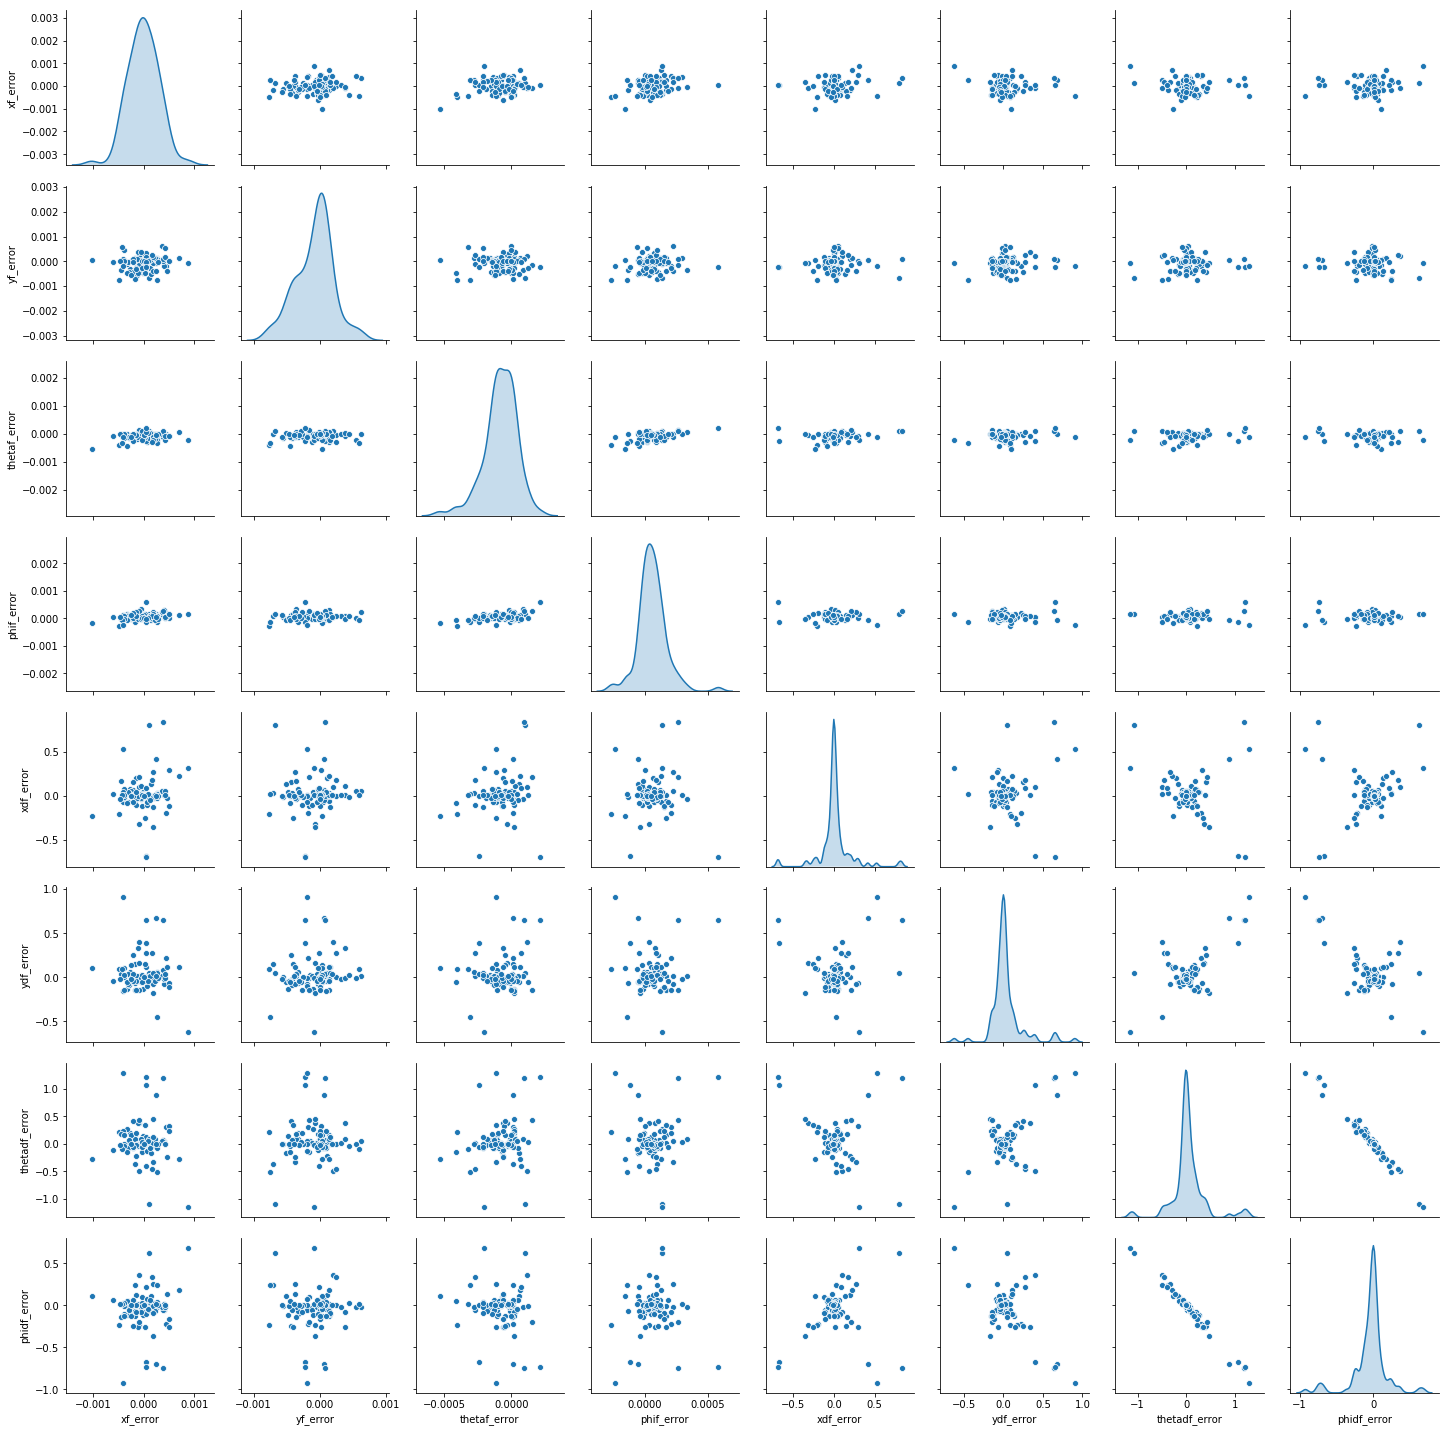

In [84]:
# this is the original check
checkData["xf_error"] = df_c.xf - checkData.x_a
checkData["yf_error"] = df_c.yf - checkData.y_a
checkData["thetaf_error"] = df_c.thetaf - checkData.theta_a
checkData["phif_error"] = df_c.phif - checkData.phi_a
checkData["xdf_error"] = df_c.xdf - checkData.xd_a
checkData["ydf_error"] = df_c.ydf - checkData.yd_a
checkData["thetadf_error"] = df_c.thetadf - checkData.thetad_a
checkData["phidf_error"] = df_c.phidf - checkData.phid_a


# plot errors
sns.pairplot(checkData.loc[:, ["xf_error", "yf_error", "thetaf_error", "phif_error", 
                               "xdf_error", "ydf_error", "thetadf_error", "phidf_error"
                               ]], aspect = 1, diag_kind = "kde")

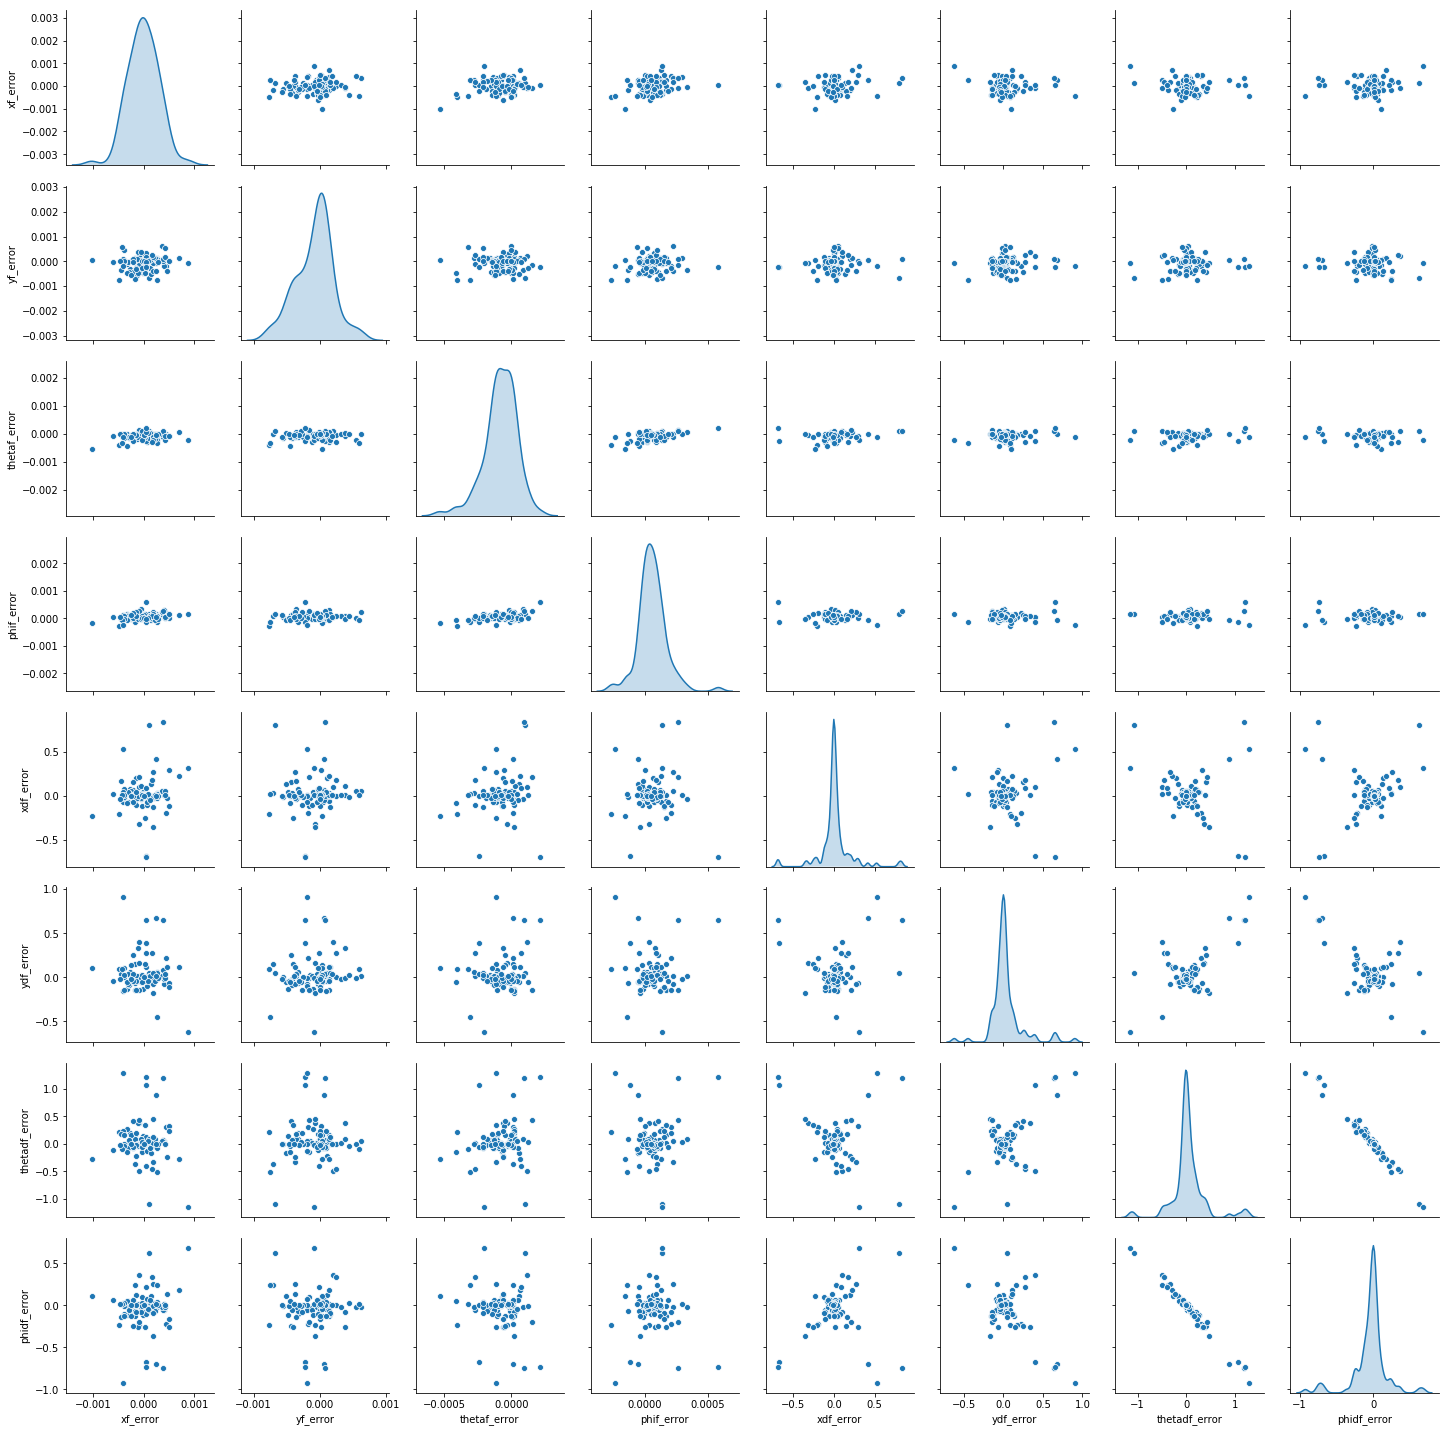

In [85]:
# this is the new check
# by eye they look pretty much identical

checkData["xf_error"] = finDF.xf - checkData.x_a
checkData["yf_error"] = finDF.yf - checkData.y_a
checkData["thetaf_error"] = finDF.thetaf - checkData.theta_a
checkData["phif_error"] = finDF.phif - checkData.phi_a
checkData["xdf_error"] = finDF.xdf - checkData.xd_a
checkData["ydf_error"] = finDF.ydf - checkData.yd_a
checkData["thetadf_error"] = finDF.thetadf - checkData.thetad_a
checkData["phidf_error"] = finDF.phidf - checkData.phid_a


# plot errors
sns.pairplot(checkData.loc[:, ["xf_error", "yf_error", "thetaf_error", "phif_error", 
                               "xdf_error", "ydf_error", "thetadf_error", "phidf_error"
                               ]], aspect = 1, diag_kind = "kde")